<a href="https://colab.research.google.com/github/gordoaraujo/cl_churn_prediction/blob/main/notebooks/Alaa_cl_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --pre pycaret
!pip install "schemdraw<0.16" #<-- To handle dependency issues

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 M

In [2]:
# for some model interpretation functions
!pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.2 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=5d69ca7abebeb9b2a277eb7f9448d43cdc22e8b559004c55efe

In [3]:
from pycaret.utils import version
version()

'3.0.2'

# Load Dep. and Data

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
import plotly.express as px

plt.rcParams["figure.figsize"] = (10, 10)  # Change matplotlib Box Size
plt.rcParams["font.size"] = 14  # Change matplotlib Font Size
plt.style.use("fivethirtyeight")

## load Data

In [5]:
orig_url = "https://drive.google.com/file/d/1h44x4nReydrfKvwwDbXjajhDvyHUCmoz/view?usp=sharing"
file_id = orig_url.split('/')[-2]
data_path='https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(data_path)

In [6]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,No,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Automatic,24.10,1734.65,No
1,Female,No,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Automatic,88.15,3973.20,No
2,Female,Yes,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Automatic,74.95,2869.85,Yes
3,Male,No,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,Male,No,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


# Data Analysis and Graphs

In [7]:
categorical_features = df.select_dtypes(exclude=['int', 'float']).columns

In [8]:
def crosstab_function(df, var):
    tab = pd.DataFrame(pd.crosstab(df[var], df["Churn"], margins=True)).reset_index()
    tab['Percentage'] = tab[1] / tab['All'] * 100
    
    tab.columns = [var, 'Churn_NO', 'Churn_YES', 'Total', 'Churn Percentage']
    return tab

In [ ]:
for i, column in enumerate(categorical_features):
    print(crosstab_function(df,column))

# Pycaret without clustring support

In [40]:
from pycaret.classification import *

clf = setup(data=df, 
            target = 'Churn', 
            train_size = 0.9,
            session_id=13, 
            experiment_name='K_1',
            n_jobs=-1)

,Description,Value
0,Session id,13
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(5986, 20)"
5,Transformed data shape,"(5986, 40)"
6,Transformed train set shape,"(5387, 40)"
7,Transformed test set shape,"(599, 40)"
8,Ordinal features,6
9,Numeric features,3


In [22]:
df.shape

(5986, 20)

In [41]:
# check the original data going into Pycaret
X_tr = get_config('X_train')
X_tr.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
727,Male,No,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.200001,19.200001
5441,Female,No,Yes,Yes,7,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.450001,150.750000
2479,Male,No,Yes,Yes,3,Yes,No,Fiber optic,Yes,Yes,No,No,Yes,No,Month-to-month,No,Electronic check,89.849998,248.399994
1408,Male,No,Yes,Yes,35,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.600000,686.950012
1915,Male,No,Yes,No,24,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.000000,2248.050049


In [42]:
# check how pycaret transforms the data
X_tr2 = get_config('X_train_transformed')
X_tr2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_No,MultipleLines_Yes,MultipleLines_No phone service,InternetService_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_Two year,Contract_One year,PaperlessBilling,PaymentMethod_Mailed check,PaymentMethod_Electronic check,PaymentMethod_Automatic,MonthlyCharges,TotalCharges
727,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,19.200001,19.200001
5441,0.0,0.0,1.0,1.0,7.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,20.450001,150.750000
2479,1.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,89.849998,248.399994
1408,1.0,0.0,1.0,1.0,35.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,19.600000,686.950012
1915,1.0,0.0,1.0,0.0,24.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,93.000000,2248.050049


In [43]:
best_model = compare_models(fold=5, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6854,0.8136,0.8446,0.4503,0.5874,0.3692,0.4171,0.5180
lda,Linear Discriminant Analysis,0.7936,0.8316,0.5392,0.6307,0.5810,0.4452,0.4478,0.3280
ada,Ada Boost Classifier,0.7978,0.8399,0.5224,0.6502,0.5786,0.4477,0.4529,0.7160
lr,Logistic Regression,0.7960,0.8388,0.5259,0.6422,0.5778,0.4450,0.4492,0.5220
gbc,Gradient Boosting Classifier,0.8023,0.8426,0.5105,0.6669,0.5777,0.4517,0.4590,0.8440
qda,Quadratic Discriminant Analysis,0.6278,0.8284,0.9124,0.4136,0.5673,0.3174,0.3959,0.3580
ridge,Ridge Classifier,0.7971,0.0000,0.4993,0.6552,0.5663,0.4370,0.4442,0.2920
lightgbm,Light Gradient Boosting Machine,0.7889,0.8271,0.5035,0.6283,0.5586,0.4222,0.4269,0.5780
rf,Random Forest Classifier,0.7904,0.8203,0.4902,0.6350,0.5532,0.4193,0.4253,0.6300
xgboost,Extreme Gradient Boosting,0.7810,0.8153,0.4930,0.6065,0.5436,0.4017,0.4055,0.3580


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

# Pycaret with clustering support

In [33]:
orig_url = "https://drive.google.com/file/d/1-U1Ib1T2QOkV3AWQaSkPsbDL25JCn01g/view?usp=sharing"
file_id = orig_url.split('/')[-2]
data_path='https://drive.google.com/uc?export=download&id=' + file_id
df_onehot = pd.read_csv(data_path)
df_onehot.dropna(inplace= True)

In [34]:
X_kmeans = df_onehot[[
       'cat_gender_Female', 'SeniorCitizen', 'cat_Partner_Yes',
        'cat_Dependents_Yes', 'tenure',
       'PhoneService',
       'cat_InternetService_DSL', 'cat_InternetService_Fiber optic','cat_InternetService_No',
       'cat_OnlineSecurity_No', 'cat_OnlineSecurity_Yes',
       'cat_OnlineBackup_No','cat_OnlineBackup_Yes',
        'cat_DeviceProtection_No', 'cat_DeviceProtection_Yes',
       'cat_TechSupport_No',  'cat_TechSupport_Yes',
       'cat_StreamingTV_No', 'cat_StreamingTV_Yes',
       'cat_StreamingMovies_No','cat_StreamingMovies_Yes',
       'cat_Contract_Month-to-month', 'cat_Contract_One year','cat_Contract_Two year',
       'cat_PaymentMethod_Automatic','cat_PaymentMethod_Electronic check', 'cat_PaymentMethod_Mailed check',
        'cat_PaperlessBilling_Yes', 'MonthlyCharges', 'TotalCharges'
       ]].copy()


In [35]:
from sklearn.cluster import KMeans
K_means = KMeans(n_clusters=4)
Kmeans_labels4 = K_means.fit_predict(X_kmeans)
df['Kmeans_4'] = Kmeans_labels4

In [36]:
clf = setup(data=df, 
            target = 'Churn', 
            train_size = 0.9,
            session_id=13, 
            experiment_name='K_1',
            n_jobs=-1)

,Description,Value
0,Session id,13
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(5986, 21)"
5,Transformed data shape,"(5986, 41)"
6,Transformed train set shape,"(5387, 41)"
7,Transformed test set shape,"(599, 41)"
8,Ordinal features,6
9,Numeric features,4


In [37]:
best_model = compare_models(fold=5, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6881,0.8146,0.8438,0.4528,0.5893,0.3730,0.4201,0.5960
qda,Quadratic Discriminant Analysis,0.6893,0.8125,0.8138,0.4534,0.5815,0.3653,0.4060,0.5580
gbc,Gradient Boosting Classifier,0.8029,0.8431,0.5133,0.6677,0.5799,0.4540,0.4610,2.0780
lda,Linear Discriminant Analysis,0.7965,0.8316,0.5287,0.6432,0.5799,0.4473,0.4514,0.5580
ada,Ada Boost Classifier,0.7978,0.8399,0.5224,0.6502,0.5786,0.4477,0.4529,1.0540
lr,Logistic Regression,0.7973,0.8386,0.5203,0.6478,0.5767,0.4455,0.4504,2.7420
ridge,Ridge Classifier,0.7997,0.0000,0.4895,0.6690,0.5647,0.4386,0.4481,0.5120
lightgbm,Light Gradient Boosting Machine,0.7895,0.8281,0.5070,0.6277,0.5605,0.4243,0.4287,1.5160
rf,Random Forest Classifier,0.7908,0.8175,0.4860,0.6381,0.5516,0.4185,0.4251,1.9960
xgboost,Extreme Gradient Boosting,0.7798,0.8183,0.5035,0.6011,0.5480,0.4040,0.4068,1.5160


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

# Create model

In [44]:
nb = create_model('nb', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6902,0.8253,0.8601,0.4556,0.5956,0.3809,0.4317
1,0.6642,0.7875,0.8182,0.4301,0.5639,0.3313,0.3768
2,0.7029,0.8259,0.8702,0.4670,0.6078,0.4018,0.4525
3,0.6769,0.7973,0.8386,0.4418,0.5787,0.3552,0.4034
4,0.6927,0.8319,0.8357,0.4570,0.5909,0.3769,0.4212
Mean,0.6854,0.8136,0.8446,0.4503,0.5874,0.3692,0.4171
Std,0.0134,0.0177,0.0185,0.0129,0.0150,0.0241,0.0257


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [45]:
nb

GaussianNB(priors=None, var_smoothing=1e-09)

In [59]:
tuned_nb2 = tune_model(nb, 
                      n_iter=16, 
                      search_library='scikit-learn', 
                      search_algorithm='grid',
                      custom_grid={
                          'var_smoothing': np.logspace(0,-9, num=100)
                      },
                      optimize='f1',
                      fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7440,0.7971,0.7098,0.5126,0.5953,0.4151,0.4269
1,0.7412,0.7822,0.6713,0.5093,0.5792,0.3974,0.4053
2,0.7558,0.8113,0.7193,0.5284,0.6092,0.4376,0.4486
3,0.7279,0.7864,0.6947,0.4901,0.5747,0.3834,0.3960
4,0.7632,0.8195,0.7203,0.5407,0.6177,0.4512,0.4609
Mean,0.7464,0.7993,0.7031,0.5162,0.5952,0.4169,0.4275
Std,0.0122,0.0143,0.0183,0.0173,0.0166,0.0250,0.0247


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [52]:
tuned_nb = tune_model(nb, 
                      n_iter=16, 
                      search_library='scikit-learn', 
                      search_algorithm='random',
                      custom_grid={
                          'var_smoothing': np.logspace(0,-9, num=100)
                      },
                      optimize='f1',
                      fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7319,0.8099,0.7483,0.4965,0.5969,0.4082,0.4274
1,0.7189,0.7890,0.7273,0.4804,0.5786,0.3807,0.3991
2,0.7428,0.8201,0.7754,0.5092,0.6147,0.4339,0.4555
3,0.7122,0.7960,0.7193,0.4713,0.5694,0.3671,0.3856
4,0.7437,0.8299,0.7587,0.5118,0.6113,0.4307,0.4493
Mean,0.7299,0.8090,0.7458,0.4938,0.5942,0.4041,0.4234
Std,0.0126,0.0150,0.0205,0.0159,0.0178,0.0266,0.0273


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [53]:
tuned_nb

GaussianNB(priors=None, var_smoothing=2.310129700083158e-07)

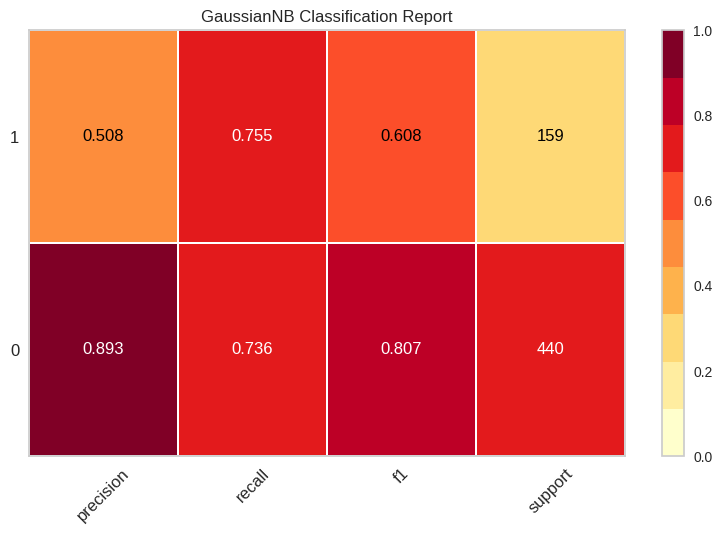

In [54]:
plot_model(tuned_nb, plot='class_report')

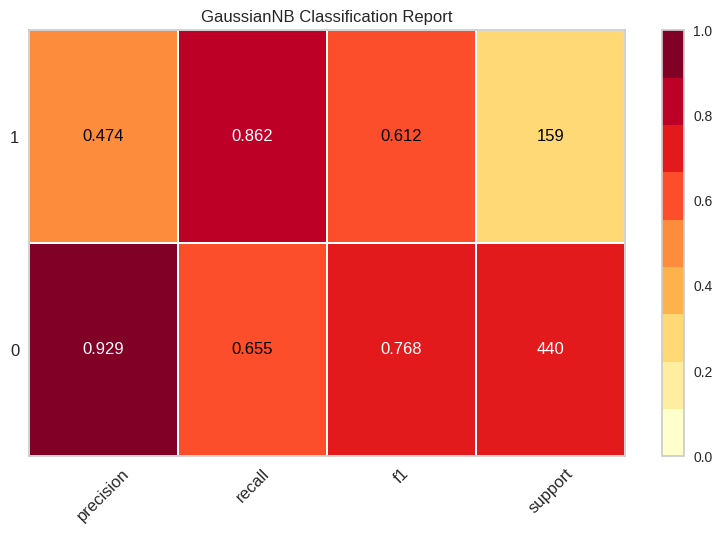

In [51]:
plot_model(nb, plot='class_report')

In [56]:
predict_model(nb)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7095,0.8270,0.8616,0.4740,0.6116,0.4093,0.4561


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
5286,Female,No,Yes,Yes,65,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Automatic,26.000000,1654.849976,0,No,1.0000
1817,Female,No,Yes,Yes,22,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,No,Mailed check,61.150002,1422.050049,1,No,0.6029
4337,Male,No,Yes,Yes,13,Yes,No,DSL,Yes,No,...,No,No,Month-to-month,Yes,Mailed check,49.950001,587.450012,0,Yes,0.9828
5268,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,Yes,Automatic,20.200001,20.200001,1,No,1.0000
5010,Male,No,Yes,No,22,Yes,No,Fiber optic,No,No,...,Yes,No,Month-to-month,Yes,Automatic,87.000000,1850.650024,0,Yes,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,Male,Yes,Yes,Yes,8,Yes,No,Fiber optic,No,No,...,Yes,No,Month-to-month,Yes,Automatic,80.449997,583.450012,1,Yes,1.0000
5108,Female,No,Yes,Yes,23,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Automatic,75.300003,1702.900024,0,Yes,0.9998
3440,Female,No,Yes,No,24,Yes,Yes,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Mailed check,79.650002,1928.699951,0,Yes,1.0000
3381,Male,No,Yes,No,49,Yes,Yes,DSL,Yes,No,...,Yes,Yes,One year,No,Electronic check,84.349998,4059.350098,1,No,0.9988


In [55]:
predict_model(tuned_nb) # check performance on the 10% held out data from train

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7412,0.8313,0.7547,0.5085,0.6076,0.4253,0.4438


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
5286,Female,No,Yes,Yes,65,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Automatic,26.000000,1654.849976,0,No,0.9964
1817,Female,No,Yes,Yes,22,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,No,Mailed check,61.150002,1422.050049,1,No,0.5389
4337,Male,No,Yes,Yes,13,Yes,No,DSL,Yes,No,...,No,No,Month-to-month,Yes,Mailed check,49.950001,587.450012,0,Yes,0.6533
5268,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,Yes,Automatic,20.200001,20.200001,1,No,0.8622
5010,Male,No,Yes,No,22,Yes,No,Fiber optic,No,No,...,Yes,No,Month-to-month,Yes,Automatic,87.000000,1850.650024,0,Yes,0.7805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,Male,Yes,Yes,Yes,8,Yes,No,Fiber optic,No,No,...,Yes,No,Month-to-month,Yes,Automatic,80.449997,583.450012,1,Yes,0.8862
5108,Female,No,Yes,Yes,23,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Automatic,75.300003,1702.900024,0,Yes,0.7466
3440,Female,No,Yes,No,24,Yes,Yes,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Mailed check,79.650002,1928.699951,0,Yes,0.7915
3381,Male,No,Yes,No,49,Yes,Yes,DSL,Yes,No,...,Yes,Yes,One year,No,Electronic check,84.349998,4059.350098,1,No,0.8878


#Prediction interpertation

In [66]:
prediction_prob =predict_model(nb)['']
#['prediction_score']

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7095,0.8270,0.8616,0.4740,0.6116,0.4093,0.4561


In [75]:
prediction_prob.iloc[[0]]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
5286,Female,No,Yes,Yes,65,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Automatic,26.0,1654.849976,0,No,1.0


In [98]:
for column in df.columns:
  print(column, "\n ----------\n",df[column].value_counts(normalize = True),'\n-----------------------\n')

gender 
 ----------
 Male      0.509522
Female    0.490478
Name: gender, dtype: float64 
-----------------------

SeniorCitizen 
 ----------
 No     0.838623
Yes    0.161377
Name: SeniorCitizen, dtype: float64 
-----------------------

Partner 
 ----------
 No     0.514868
Yes    0.485132
Name: Partner, dtype: float64 
-----------------------

Dependents 
 ----------
 No     0.700802
Yes    0.299198
Name: Dependents, dtype: float64 
-----------------------

tenure 
 ----------
 1     0.085199
72    0.051453
2     0.032409
3     0.028233
4     0.025727
        ...   
45    0.007852
44    0.007852
39    0.007350
36    0.007183
0     0.001671
Name: tenure, Length: 73, dtype: float64 
-----------------------

PhoneService 
 ----------
 Yes    0.901437
No     0.098563
Name: PhoneService, dtype: float64 
-----------------------

MultipleLines 
 ----------
 No                  0.475777
Yes                 0.425660
No phone service    0.098563
Name: MultipleLines, dtype: float64 
-------------

# Feature Selection

In [57]:
#plot_model(tuned_nb, plot='feature') 

TypeError: ignored

In [ ]:
#evaluate_model(tuned_lightgbm)

In [58]:
#interpret_model(tuned_nb, plot='summary')

TypeError: ignored